In [84]:
# Google Colab 환경에서 작성
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [85]:
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import random
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import seaborn as sns

In [86]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(41) # Seed 고정

In [87]:
train_df = pd.read_csv('/content/drive/MyDrive/인공지능응용/train_T.csv')
train_df = train_df.drop(columns='PRODUCT_CODE')
train_df['LINE'] = train_df['LINE'].replace({'T100304':0, 'T100306':1})
train_df['Y_Class'] = train_df['Y_Class'].replace({0:1, 2:1, 1:0}) # 이상치는 1, 정상은 0
train_df = train_df.fillna(0)


val_df = train_df[train_df['Y_Class']==1]
train_df = train_df[train_df['Y_Class']==0]

In [88]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

In [89]:
batch_size = 32

In [90]:
class MyDataset(Dataset):
    def __init__(self, df, eval_mode):
        self.df = df
        self.eval_mode = eval_mode
        self.labels = self.df['Y_Class'].values
        self.conds = self.df['LINE'].values
        self.df = self.df.drop(columns=['Y_Class'])
        self.df = self.df.drop(columns=['Y_Quality'])
        self.df = self.df.drop(columns=['LINE'])
        self.df = self.df.values

    def __getitem__(self, index):
        if self.eval_mode:
            self.x = self.df[index]
            self.y = self.labels[index]
            return torch.Tensor(self.x), self.y
        else:
            self.x = self.df[index]
            return torch.Tensor(self.x)

    def __len__(self):
        return len(self.df)

In [91]:
train_dataset = MyDataset(df=train_df, eval_mode=False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = MyDataset(df = val_df, eval_mode=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [92]:
class GANnomaly(object):

    def __init__(self):
        self.encoder = Encoder().to(device)
        self.decoder = Decoder().to(device)
        self.discriminator = Discriminator().to(device)

        self.models = [self.encoder, self.decoder, self.discriminator]

        self.params = None
        for idx_m, model in enumerate(self.models):
            if (self.params is None):
                self.params = list(model.parameters())
            else:
                self.params = self.params + list(model.parameters())

        self.optimizer = optim.Adam(self.params, lr=0.001)

class Encoder(nn.Module):

    def __init__(self):
        super(Encoder, self).__init__()

        self.encoder = nn.Sequential(
          nn.Linear(1132, 512),
          nn.BatchNorm1d(512),
          nn.LeakyReLU(),
          nn.Linear(512, 256),
          nn.BatchNorm1d(256),
          nn.LeakyReLU(),
          nn.Linear(256, 128),
          nn.BatchNorm1d(128),
          nn.LeakyReLU(),
          nn.Linear(128, 64),
          nn.BatchNorm1d(64),
          nn.LeakyReLU(),
        )

    def forward(self, x):

        z_code = self.encoder(x)

        return z_code

class Decoder(nn.Module):

    def __init__(self):
        super(Decoder, self).__init__()

        self.decoder = nn.Sequential(
          nn.Linear(64, 128),
          nn.BatchNorm1d(128),
          nn.LeakyReLU(),
          nn.Linear(128, 256),
          nn.BatchNorm1d(256),
          nn.LeakyReLU(),
          nn.Linear(256, 512),
          nn.BatchNorm1d(512),
          nn.LeakyReLU(),
          nn.Linear(512, 1132)
        )

    def forward(self, x):

        x_hat = self.decoder(x)

        return x_hat



class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()

        self.dis_dense = nn.Sequential(
            nn.Linear(1132, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):

        featurebank = []

        for idx, layer in enumerate(self.dis_dense):
            x = layer(x)
            if("torch.nn.modules.activation" in str(type(layer))):
                featurebank.append(x)
        disc_score = x

        return disc_score, featurebank

In [93]:
def loss_enc(z_code, z_code_hat):

    l_enc = torch.sum((z_code - z_code_hat)**2, dim=(1))

    return l_enc

def loss_rec(x, x_hat):
    l_con = torch.sum(torch.abs(x - x_hat), dim=(1))

    return l_con

def loss_adv(dis_x, dis_x_hat, features_real, features_fake):

    l_adv = torch.sum((dis_x - dis_x_hat)**2, dim=(1))


    for fidx, _ in enumerate(features_real):

        l_adv += torch.sum((features_real[fidx] - features_fake[fidx])**2, dim=(1))

    return l_adv


def loss_gan(z_code, z_code_hat, x, x_hat,
    dis_x, dis_x_hat, features_real, features_fake,
    w_enc=1, w_con=10, w_adv=1):


    z_code, z_code_hat, x, x_hat = z_code, z_code_hat, x, x_hat

    for fidx, _ in enumerate(features_real):
        features_real[fidx] = features_real[fidx]
        features_fake[fidx] = features_fake[fidx]

    l_enc = loss_enc(z_code, z_code_hat)
    l_con = loss_rec(x, x_hat)
    l_adv = loss_adv(dis_x, dis_x_hat, features_real, features_fake)


    l_tot = torch.mean((w_enc * l_enc) + (w_con * l_con) + (w_adv * l_adv))

    l_enc = torch.mean(l_enc)
    l_con = torch.mean(l_con)
    l_adv = torch.mean(l_adv)


    return l_tot, l_enc, l_con, l_adv

In [94]:
epochs = 3000
cos = nn.CosineSimilarity(dim=1, eps=1e-8)

model = GANnomaly()
model.encoder.train()
model.decoder.train()
model.discriminator.train()

encoder_loss_per_epoch = []
decoder_loss_per_epoch = []

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(model.optimizer, mode='min', factor=0.3, patience=15, threshold_mode='abs', min_lr=1e-8, verbose=True)

for i in range(1,epochs+1) :

    train_loss = []
    encoder_loss = []
    decoder_loss = []
    disc_loss = []
    best_score = 0

    for idx, data in enumerate(train_loader):

        x = data.to(device)

        z_code = model.encoder(x)
        x_hat = model.decoder(z_code)
        z_code_hat = model.encoder(x_hat)

        dis_x, features_real = model.discriminator(x)
        dis_x_hat, features_fake = model.discriminator(x_hat)


        l_tot, l_enc, l_con, l_adv = loss_gan(z_code, z_code_hat,
                                       x, x_hat,
                                       dis_x, dis_x_hat,
                                       features_real, features_fake)

        model.optimizer.zero_grad()
        l_tot.backward()
        model.optimizer.step()

        train_loss.append(l_tot.item())
        encoder_loss.append(l_enc.item())
        decoder_loss.append(l_con.item())
        disc_loss.append(l_adv.item())

        encoder_loss_per_epoch.append(l_enc.item())
        decoder_loss_per_epoch.append(l_con.item())


    print(f'Epoch : [{i}] Train loss : [{np.mean(train_loss)}] Encoder loss : [{np.mean(encoder_loss)}] Decoder loss : [{np.mean(decoder_loss)}] Disc loss : [{np.mean(disc_loss)}] )')

    score = np.mean(train_loss)
   # scheduler.step(score)
    scheduler.step(np.mean(train_loss))

    if best_score < score:
        best_score = score
        torch.save(model.encoder.state_dict(), 'best_encoder.pth', _use_new_zipfile_serialization=False)
        torch.save(model.decoder.state_dict(), 'best_decoder.pth', _use_new_zipfile_serialization=False)

Epoch : [1] Train loss : [10138199.35] Encoder loss : [20.184555530548096] Decoder loss : [202759.0671875] Disc loss : [225.90677604675292] )
Epoch : [2] Train loss : [10061528.1] Encoder loss : [9.62342402935028] Decoder loss : [201228.89765625] Disc loss : [73.70102024078369] )
Epoch : [3] Train loss : [9905316.35] Encoder loss : [8.211378693580627] Decoder loss : [198105.34296875] Disc loss : [41.004147148132326] )
Epoch : [4] Train loss : [9839042.65] Encoder loss : [7.188227915763855] Decoder loss : [196780.24453125] Disc loss : [23.253650760650636] )
Epoch : [5] Train loss : [9733201.1] Encoder loss : [6.098397445678711] Decoder loss : [194663.5890625] Disc loss : [15.692071580886841] )
Epoch : [6] Train loss : [9608567.35] Encoder loss : [4.187218582630157] Decoder loss : [192171.0703125] Disc loss : [9.644352126121522] )
Epoch : [7] Train loss : [9483847.725] Encoder loss : [3.0839455008506773] Decoder loss : [189676.75625] Disc loss : [7.136877322196961] )
Epoch : [8] Train lo

KeyboardInterrupt: ignored

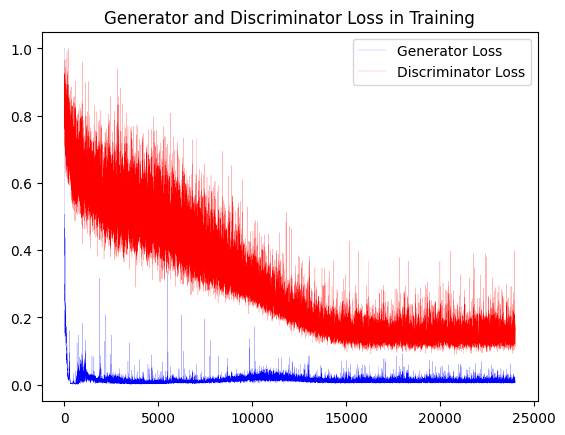

In [101]:
#visualize results
import matplotlib.pyplot as plt

vis_encoder_loss = [x / max(encoder_loss_per_epoch) for x in encoder_loss_per_epoch]
vis_decoder_loss = [x / max(decoder_loss_per_epoch) for x in decoder_loss_per_epoch]


plt.plot(vis_encoder_loss,'b',label='Generator Loss',linewidth=0.1)
plt.plot(vis_decoder_loss,'r',label='Discriminator Loss',linewidth=0.1)

plt.title('Generator and Discriminator Loss in Training')
plt.legend()
plt.show()

In [102]:
model = GANnomaly()
model.encoder.load_state_dict(torch.load('best_encoder.pth'))
model.decoder.load_state_dict(torch.load('best_decoder.pth'))
model.encoder.eval()
model.decoder.eval()

Decoder(
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=128, out_features=256, bias=True)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=256, out_features=512, bias=True)
    (7): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Linear(in_features=512, out_features=1132, bias=True)
  )
)

In [103]:
val_dataset = MyDataset(df = val_df, eval_mode=True)
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)

In [104]:
model.encoder.eval()
model.decoder.eval()
val_sim = np.zeros(0)

with torch.no_grad():
    for data, label in val_loader:
        data, target = data.to(device), data.cpu()
        output = model.decoder(model.encoder(data))
        output = output.reshape(-1,1132).cpu()
        target = target.reshape(-1,1132)
        val_sim = np.append(val_sim, cos(output,target))

In [105]:
thr = 0.5

pred_GAN = np.where(val_sim < thr,1,0)

print(f1_score(pred_GAN,val_df['Y_Class'],average='macro'))
print(confusion_matrix(val_df['Y_Class'],pred_GAN))

0.0
[[  0   0]
 [200   0]]


In [106]:
print(classification_report(val_df['Y_Class'],pred_GAN))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00     200.0

    accuracy                           0.00     200.0
   macro avg       0.00      0.00      0.00     200.0
weighted avg       0.00      0.00      0.00     200.0



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

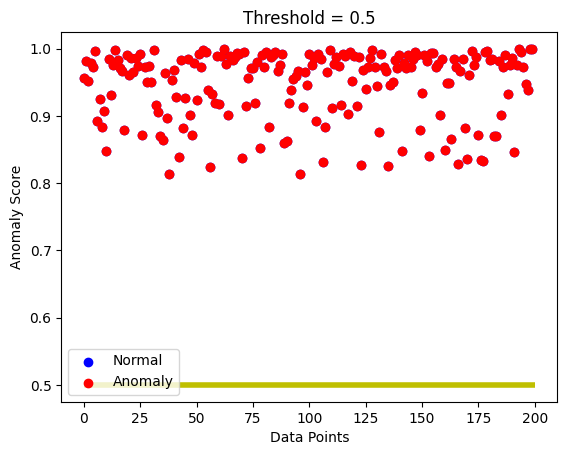

In [111]:
# 시각화 코드 추가
threshold_vis = 0.5
threshold_score = 0.5

plt.scatter(range(len(val_sim)), val_sim, c='b', label='Normal')
plt.scatter(np.array(range(len(val_sim)))[val_df['Y_Class'] == 1], val_sim[val_df['Y_Class'] == 1], c='r', label='Anomaly')
plt.hlines(threshold_score, xmin=0, xmax=len(val_sim), colors='y', linewidth=4)

plt.title(f'Threshold = {threshold_vis}')
plt.xlabel('Data Points')
plt.ylabel('Anomaly Score')
plt.legend()
plt.show()